In [1]:
%config Completer.use_jedi = False
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from pandas.api.types import CategoricalDtype
import math
import matplotlib as mpl
#mpl.use('pdf')
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
from collections import OrderedDict
import matplotlib
import seaborn as sns
from pylab import cm
from matplotlib.cbook import boxplot_stats
from matplotlib.legend_handler import HandlerTuple

from scipy.stats.mstats import hmean

from pprint import pprint
from IPython.display import display, HTML

import subprocess
import warnings 
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# this is used to set limits on the y-axis for each device separately
y_limit_dictionary = {
    'Tesla-P100' : [0, 100], 
    'Tesla-V100' : [0, 140], 
    'Tesla-A100' : [0, 230], 
    'Grace-H100' : [0, 630], 
    'AMD-MI250' : [0, 230], 
    
    'AMD-EPYC-64' : [0, 175], 
    'AMD-EPYC-24' : [0, 110], 
    'ARM-NEON' : [0, 190], 
    'ARM-GRACE' : [0, 280], 
    'INTEL-XEON' : [0, 50], 
    'INTEL-ICY' : [0, 70], 
    'INTEL-SAPPHIRE' : [0, 250], 
    'IBM-POWER9' : [0, 55], 
    'Alveo-U280' : [0, 30], 
}

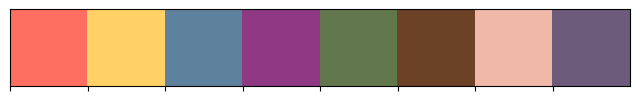

In [3]:
palette = [
    '#FF6F61','#FFD166','#5E819D','#8F3985',# '#A2A18F','#3C6E71','#D5AB9C','#7D9EA8',
    # '#D9BF77','#EAD3C6','#A8D0DB','#7A9D7E',
    # '#355C7D','#ACD8AA','#FFE156',
    '#63774D','#6B4226','#F0B8A6','#6C5B7B',
    
]
sns.palplot(palette)
plt.show()

In [4]:
def change_colors(ranges_dev, color_dictionary):
    color_dictionary_custom = {k: v for k, v in color_dictionary.items() if k in ranges_dev}
    sns.set_palette(color_dictionary_custom.values())
    sns.color_palette()


# all devices that will be used
# ranges_dev = ['Grace-H100', 'Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9', 'Alveo-U280']
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 
              'Grace-H100', 'AMD-MI250',
              'AMD-EPYC-64', 'ARM-GRACE', 'INTEL-SAPPHIRE']

color_dictionary = dict(zip(ranges_dev, palette[:len(ranges_dev)]))

sns.set_palette(color_dictionary.values())
sns.color_palette()


[(1.0, 0.43529411764705883, 0.3803921568627451),
 (1.0, 0.8196078431372549, 0.4),
 (0.3686274509803922, 0.5058823529411764, 0.615686274509804),
 (0.5607843137254902, 0.2235294117647059, 0.5215686274509804),
 (0.38823529411764707, 0.4666666666666667, 0.30196078431372547),
 (0.4196078431372549, 0.25882352941176473, 0.14901960784313725),
 (0.9411764705882353, 0.7215686274509804, 0.6509803921568628),
 (0.4235294117647059, 0.3568627450980392, 0.4823529411764706)]

In [5]:
# original for IEEE paper
width = 3.487
height = width/1.618

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'font.size': 7})

In [6]:
# "dodge" argument explained here -> https://stackoverflow.com/questions/49078697/seaborn-boxplots-shifted-incorrectly-along-x-axis 
def harry_plotter(type, plot_df, plot_x_axis_list, plot_y_axis_list, select_str, plot_id, 
                  boxplot_width = 0.8, rotation = 30, adj_left = .1, adj_bottom = .2, adj_right = .99, adj_top = .88, 
                  no_sort=False, hue_hue = 'None', hue_hue_order = [], dodge=True, no_legend=False, no_title=True,
                  show_size=False, systemaki='',
                  no_x_axis=False, no_x_axis_title=False, add_separators = False,
                  secondary_axis=False, plot_secondary_y_itter = '', secondary_data = [], secondary_annot = [],
                 ):
    for plot_x_itter in plot_x_axis_list:
        if no_sort:
            plot_df_sorted = plot_df
        else:
            dataTypeX = plot_df[plot_x_itter].dtype
            if dataTypeX == np.float64 or dataTypeX == np.int64 or dataTypeX == float or dataTypeX == int:
                plot_df_sorted = plot_df.sort_values(plot_x_itter)
            else:
                plot_df_sorted = plot_df
                if plot_x_itter == 'mem_range':
                    cat_it = CategoricalDtype(ranges_memr, ordered=True)
                if plot_x_itter == 'regularity':
                    cat_it = CategoricalDtype(ranges_regularity, ordered=True)
                if plot_x_itter == 'impl_arch':
                    cat_it = CategoricalDtype(ranges_impl_arch, ordered=True)
                if plot_x_itter == 'System':
                    cat_it = CategoricalDtype(ranges_dev, ordered=True)
                if plot_x_itter == 'anr_categ':
                    cat_it = CategoricalDtype(ranges_anr, ordered=True)
                if plot_x_itter == 'skew_categ':
                    cat_it = CategoricalDtype(ranges_skew, ordered=True)

                plot_df_sorted[plot_x_itter] = plot_df_sorted[plot_x_itter].astype(cat_it)
                plot_df_sorted = plot_df_sorted.sort_values(plot_x_itter)

        for plot_y_itter in plot_y_axis_list:
            fig, axs = plt.subplots()
            if hue_hue == 'None':
                if(type == 'violin'):
                    sns_plot = sns.violiplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
                if(type == 'scatter'):
                    sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs)
                if(type == 'box'):
                    sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
            else:
                if(hue_hue_order != []):
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                else:
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)

            if(hue_hue_order != []):               
                # reordering the labels
                handles, labels = plt.gca().get_legend_handles_labels()
                order = [labels.index(i) for i in hue_hue_order]
                plt.legend([handles[i] for i in order], [labels[i] for i in order], 
                           title = hue_hue.replace('_categ',''), fancybox=True, frameon=False)

            if(no_legend==True):
                axs.get_legend().remove()
            else:
                #remove title from Legend
                handles, labels = axs.get_legend_handles_labels()
                axs.legend(handles=handles[0:], labels=labels[0:])
                # axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(ranges_dev), frameon=False)
                axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=len(ranges_dev), frameon=False)

            if(plot_x_itter == 'impl_arch'):
                if(add_separators  == True):
                    add_where = []
                    xtick_items = axs.get_xticklabels()
                    prev_platf = xtick_items[0].get_text().split('\n')[0] # initializae previous platform
                    for item in xtick_items:
                        platf = item.get_text().split('\n')[0]
                        if(platf!=prev_platf):
                            # when changing which platform is shown, add a separator right before
                            # to make it distinct from previous
                            add_where.append(item.get_position()[0]-0.5)
                        prev_platf = platf
                            
                    for pos in add_where:
                        plt.axvline(x=pos, color='gray', linewidth=0.15)
                
                # remove "arch" from "impl_arch"
                labels = [item.get_text().split("\n")[1] for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels)
                axs.set_xlabel('Format name')

            if(plot_y_itter == 'energy_efficiency'):
                axs.set_ylabel("GFLOPs/W")
                # I set this limit as some outliers ( from Vectorized CSR ) caused it to reach 2.5
                # and compared to other devices, offered nothing more
                axs.set_ylim(bottom = 0, top=1.4)
            if(plot_y_itter == 'GFLOPs^2-per-W'):
                axs.set_ylabel("GFLOPs^2/W")
            if(plot_y_itter == 'gflops'):
                axs.set_ylabel("GFLOPs")
            if(plot_x_itter == 'anr_categ'):
                axs.set_xlabel('avg_nz_row')
            if(plot_x_itter == 'skew_categ'):
                axs.set_xlabel('skew_coefficient')
            if(plot_x_itter == 'regularity'):
                axs.set_xlabel('regularity ( cross_row_similarity / avg_num_neighbours )')

            if(no_title==False):
                # axs.set_title('Select: %s' %(select_str))
                axs.set_title('%s' %(select_str))

            if(show_size==True):
                if(plot_x_itter=='System' or plot_x_itter=='mem_range' or plot_x_itter=='regularity' or plot_x_itter=='anr_categ' or plot_x_itter=='skew_categ'):
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==item.get_text()].shape[0])  +')' for item in axs.get_xticklabels()]
                else:
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==float(item.get_text())].shape[0])  +')' for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels_new, fontsize = font)
                plt.xticks(rotation=45)#rotation)

            if(no_x_axis_title==True):
                axs.set_xlabel("")
            if(no_x_axis==True):
                axs.set_xticklabels([])
                axs.set_xlabel("")
                axs.set_xticks([], minor=False)#, major=False)
                
            if(secondary_axis==True):
                axs2 = axs.twinx()
                axs2.bar(range(0, len(secondary_data)), height=secondary_data,align='center', width = 0.6, alpha=0.19)
                
                if(plot_secondary_y_itter == 'mem_bw'):
                    axs2.set_ylabel("Memory Bandwidth (GB/s)")
                if(plot_secondary_y_itter == 'wins'):
                    axs2.set_ylabel("Wins percentage (%)")
                
                if(secondary_annot != []):
                    items = axs.get_xticklabels()
                    labels = [items[i].get_text() + '\n' + '(' + str(secondary_annot[i]) + '% peak performance)'  for i in range(len(items))]
                    axs.set_xticklabels(labels)

            if(systemaki != ''):
                axs.text( 0.02, 0.9, systemaki, fontsize=font, transform = axs.transAxes, )

            fig.subplots_adjust(left=adj_left, bottom=adj_bottom, right=adj_right, top=adj_top)

            plt.xticks(rotation=rotation)
            plt.setp( axs.xaxis.get_majorticklabels(), rotation=rotation )

            plt.tight_layout()

            select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')            
            if('-performance_' in select_str_id):
                select_str_id = select_str_id.split('-performance_')[0]
            else:
                select_str_id = select_str_id.split('__')[0]

            fig_name = './Plots/%s_Select-%s_x-%s_y-%s.pdf' % (plot_id, select_str_id, plot_x_itter, plot_y_itter)
            fig.savefig(fig_name)            
            plt.close()
            subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
            subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])
# "dodge" argument explained here -> https://stackoverflow.com/questions/49078697/seaborn-boxplots-shifted-incorrectly-along-x-axis 
def harry_plotter(type, plot_df, plot_x_axis_list, plot_y_axis_list, select_str, plot_id, 
                  boxplot_width = 0.8, rotation = 30, adj_left = .1, adj_bottom = .2, adj_right = .99, adj_top = .88, 
                  no_sort=False, hue_hue = 'None', hue_hue_order = [], dodge=True, no_legend=False, no_title=True,
                  show_size=False, systemaki='',
                  no_x_axis=False, no_x_axis_title=False, add_separators = False,
                  secondary_axis=False, plot_secondary_y_itter = '', secondary_data = [], secondary_annot = [],
                 ):
    for plot_x_itter in plot_x_axis_list:
        if no_sort:
            plot_df_sorted = plot_df
        else:
            dataTypeX = plot_df[plot_x_itter].dtype
            if dataTypeX == np.float64 or dataTypeX == np.int64 or dataTypeX == float or dataTypeX == int:
                plot_df_sorted = plot_df.sort_values(plot_x_itter)
            else:
                plot_df_sorted = plot_df
                if plot_x_itter == 'mem_range':
                    cat_it = CategoricalDtype(ranges_memr, ordered=True)
                if plot_x_itter == 'regularity':
                    cat_it = CategoricalDtype(ranges_regularity, ordered=True)
                if plot_x_itter == 'impl_arch':
                    cat_it = CategoricalDtype(ranges_impl_arch, ordered=True)
                if plot_x_itter == 'System':
                    cat_it = CategoricalDtype(ranges_dev, ordered=True)
                if plot_x_itter == 'anr_categ':
                    cat_it = CategoricalDtype(ranges_anr, ordered=True)
                if plot_x_itter == 'skew_categ':
                    cat_it = CategoricalDtype(ranges_skew, ordered=True)

                plot_df_sorted[plot_x_itter] = plot_df_sorted[plot_x_itter].astype(cat_it)
                plot_df_sorted = plot_df_sorted.sort_values(plot_x_itter)

        for plot_y_itter in plot_y_axis_list:
            fig, axs = plt.subplots()
            if hue_hue == 'None':
                if(type == 'violin'):
                    sns_plot = sns.violiplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
                if(type == 'scatter'):
                    sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs)
                if(type == 'box'):
                    sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, ax=axs, dodge=dodge)
            else:
                if(hue_hue_order != []):
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, hue_order=hue_hue_order, ax=axs, dodge=dodge)
                else:
                    if(type == 'violin'):
                        sns_plot = sns.violinplot(linewidth=0.6, width=0.4, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)
                    if(type == 'scatter'):
                        sns_plot = sns.scatterplot(data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs)
                    if(type == 'box'):
                        sns_plot = sns.boxplot(fliersize = 0.3, linewidth=0.6, width=boxplot_width, data=plot_df_sorted, x=plot_x_itter, y=plot_y_itter, hue=hue_hue, ax=axs, dodge=dodge)

            if(hue_hue_order != []):               
                # reordering the labels
                handles, labels = plt.gca().get_legend_handles_labels()
                order = [labels.index(i) for i in hue_hue_order]
                plt.legend([handles[i] for i in order], [labels[i] for i in order], 
                           title = hue_hue.replace('_categ',''), fancybox=True, frameon=False)

            if(no_legend==True):
                axs.get_legend().remove()
            else:
                #remove title from Legend
                handles, labels = axs.get_legend_handles_labels()
                axs.legend(handles=handles[0:], labels=labels[0:])
                # axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=len(ranges_dev), frameon=False)
                axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=len(ranges_dev), frameon=False)

            if(plot_x_itter == 'impl_arch'):
                if(add_separators  == True):
                    add_where = []
                    xtick_items = axs.get_xticklabels()
                    prev_platf = xtick_items[0].get_text().split('\n')[0] # initializae previous platform
                    for item in xtick_items:
                        platf = item.get_text().split('\n')[0]
                        if(platf!=prev_platf):
                            # when changing which platform is shown, add a separator right before
                            # to make it distinct from previous
                            add_where.append(item.get_position()[0]-0.5)
                        prev_platf = platf
                            
                    for pos in add_where:
                        plt.axvline(x=pos, color='gray', linewidth=0.15)
                
                # remove "arch" from "impl_arch"
                labels = [item.get_text().split("\n")[1] for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels)
                axs.set_xlabel('Format name')

            if(plot_y_itter == 'energy_efficiency'):
                axs.set_ylabel("GFLOPs/W")
                # I set this limit as some outliers ( from Vectorized CSR ) caused it to reach 2.5
                # and compared to other devices, offered nothing more
                axs.set_ylim(bottom = 0, top=1.4)
            if(plot_y_itter == 'GFLOPs^2-per-W'):
                axs.set_ylabel("GFLOPs^2/W")
            if(plot_y_itter == 'gflops'):
                axs.set_ylabel("GFLOPs")
            if(plot_x_itter == 'anr_categ'):
                axs.set_xlabel('avg_nnz_per_row')
            if(plot_x_itter == 'skew_categ'):
                axs.set_xlabel('skew_coefficient')
            if(plot_x_itter == 'regularity'):
                axs.set_xlabel('regularity ( cross_row_similarity / avg_num_neighbours )')

            if(no_title==False):
                # axs.set_title('Select: %s' %(select_str))
                axs.set_title('%s' %(select_str))

            if(show_size==True):
                if(plot_x_itter=='System' or plot_x_itter=='mem_range' or plot_x_itter=='regularity' or plot_x_itter=='anr_categ' or plot_x_itter=='skew_categ'):
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==item.get_text()].shape[0])  +')' for item in axs.get_xticklabels()]
                else:
                    labels_new = [item.get_text() + '\n('+ str(plot_df_sorted[plot_df_sorted[plot_x_itter]==float(item.get_text())].shape[0])  +')' for item in axs.get_xticklabels()]
                axs.set_xticklabels(labels_new, fontsize = font)
                plt.xticks(rotation=45)#rotation)

            if(no_x_axis_title==True):
                axs.set_xlabel("")
            if(no_x_axis==True):
                axs.set_xticklabels([])
                axs.set_xlabel("")
                axs.set_xticks([], minor=False)#, major=False)
                
            if(secondary_axis==True):
                axs2 = axs.twinx()
                axs2.bar(range(0, len(secondary_data)), height=secondary_data,align='center', width = 0.6, alpha=0.19)
                
                if(plot_secondary_y_itter == 'mem_bw'):
                    axs2.set_ylabel("Memory Bandwidth (GB/s)")
                if(plot_secondary_y_itter == 'wins'):
                    axs2.set_ylabel("Wins percentage (%)")
                
                if(secondary_annot != []):
                    items = axs.get_xticklabels()
                    labels = [items[i].get_text() + '\n' + '(' + str(secondary_annot[i]) + '% peak performance)'  for i in range(len(items))]
                    axs.set_xticklabels(labels)

            if(systemaki != ''):
                axs.text( 0.02, 0.9, systemaki, fontsize=font, transform = axs.transAxes, )

            fig.subplots_adjust(left=adj_left, bottom=adj_bottom, right=adj_right, top=adj_top)

            plt.xticks(rotation=rotation)
            plt.setp( axs.xaxis.get_majorticklabels(), rotation=rotation )

            plt.tight_layout()

            select_str_id = select_str.replace('=', 'eq').replace('<', 'l').replace('>', 'g').replace(', ', '_').replace(',', '_').replace('\n', '_').replace(' ', '-')            
            if('-performance_' in select_str_id):
                select_str_id = select_str_id.split('-performance_')[0]
            else:
                select_str_id = select_str_id.split('__')[0]

            fig_name = './Plots/%s_Select-%s_x-%s_y-%s.pdf' % (plot_id, select_str_id, plot_x_itter, plot_y_itter)
            fig.savefig(fig_name)            
            plt.close()
            subprocess.run(['pdfcrop', fig_name], stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
            subprocess.run(['mv', fig_name.replace('.pdf', '-crop.pdf'), fig_name])


---
# Some general use functions and variables

In [7]:
header_names = ['matrix_name','distribution','placement','seed',
                'nr_rows','nr_cols','nr_nzeros','density','mem_footprint','mem_range',
                'avg_nnz_per_row','std_nnz_per_row',
                'avg_bw','std_bw','avg_bw_scaled','std_bw_scaled',
                'avg_sc','std_sc','avg_sc_scaled','std_sc_scaled',
                'skew','avg_num_neighbours','cross_row_similarity',
                'format_name','time','gflops','W_avg','J_estimated', 'System', 'Arch']

# precision = 'f'
precision = 'd' # for double-precision arithmetic

def remove_formats(df, formats_to_discard):
    for ftd in formats_to_discard:
        df = df[df['format_name'] != ftd]
    return df

def print_formats_per_device(df):
    print('------------------------')
    print('Size of dataframe')
    print(df.shape)
    print('Tested formats')
    print(set(df['format_name']))
    print('Tested formats per device:')
    for sys in set(df['System']):
        df_sys = df[df['System'] == sys]
        print(sys, '\t', set(df_sys['format_name']))
    print('------------------------')

---
# Read GPU data

In [8]:
%%time 
inputdata_GPU_V100 = pd.read_csv('../benchmark_results/vulcan-V100/vulcan-V100_dtype-D_run_full_dataset.csv', names = header_names)
inputdata_GPU_V100['System'] = 'Tesla-V100'

inputdata_GPU_P100 = pd.read_csv('../benchmark_results/vulcan-P100/vulcan-P100_dtype-D_run_full_dataset.csv', names = header_names)
inputdata_GPU_P100['System'] = 'Tesla-P100'

inputdata_GPU_A100 = pd.read_csv('../benchmark_results/epyc5-A100/epyc5-A100_dtype-D_run_synthetic_matrices_small_dataset.csv', names = header_names)
inputdata_GPU_A100['System'] = 'Tesla-A100'

# inputdata_GPU_H100 = pd.read_csv('../benchmark_results/grace1-H100/grace1-H100_dtype-D_run_synthetic_matrices_small_dataset.csv', names = header_names)
inputdata_GPU_H100 = pd.read_csv('../benchmark_results/grace1-H100/grace1-H100_synthetic_d.csv')
inputdata_GPU_H100['System'] = 'Grace-H100'

inputdata_GPU_MI250 = pd.read_csv('../benchmark_results/amd-mi250/amd-mi250_synthetic_d.csv')
inputdata_GPU_MI250['System'] = 'AMD-MI250'

inputdata_GPU = pd.concat([inputdata_GPU_V100, inputdata_GPU_P100, inputdata_GPU_A100, inputdata_GPU_H100, inputdata_GPU_MI250])
# inputdata_GPU = pd.concat([inputdata_GPU_H100, inputdata_GPU_MI250])
# inputdata_GPU = pd.concat([inputdata_GPU_H100])
inputdata_GPU['Arch'] = 'GPU'

# nothing to discard here!
formats_to_discard = []
inputdata_GPU = remove_formats(inputdata_GPU, formats_to_discard)

print_formats_per_device(inputdata_GPU)

# inputdata_GPU = inputdata_GPU.round({'nz': -1, 'mem_footprint': 3, 'density': 3,
#              'avg_nnz_row': 3, 'std_nnz_row': 3,
#              'avg_bandwidth': -1, 'std_bandwidth': -1, 'avg_bandwidth_scaled': 2, 'std_bandwidth_scaled': 2,
#              'avg_scattering': 2, 'std_scattering': 2, 'avg_scattering_scaled': -1, 'std_scattering_scaled': -1,
#              'skew_coeff': 1,
#              'avg_num_neighbours' : 3, 'cross_row_similarity': 3})

------------------------
Size of dataframe
(1106813, 30)
Tested formats
{'ROCSPARSE_CSR', 'ACC_FLAT_b512', 'CUSPARSE_CSR', 'SELL-32-1', 'Custom_CSR_CUDA_ADAPTIVE_b512_1', 'Merge_11', 'Custom_CSR_ROCM_constant_nnz_per_thread_b512_nnz4', 'Custom_CSR_CUDA_constant_nnz_per_thread_b1024_nnz4', 'ACC_LINE_ENHANCE_b512', 'ROCSPARSE_COO', 'cuSPARSE_coo11', 'ROCSPARSE_HYB', 'cuSPARSE_hyb9-2', 'cuSPARSE_csr11', 'CSR5_9', 'Custom_CSR_ROCM_VECTOR_b512'}
Tested formats per device:
Tesla-A100 	 {'Merge_11', 'SELL-32-1', 'cuSPARSE_coo11', 'cuSPARSE_csr11'}
Tesla-P100 	 {'CSR5_9', 'cuSPARSE_coo11', 'cuSPARSE_hyb9-2', 'cuSPARSE_csr11'}
Grace-H100 	 {'CUSPARSE_CSR', 'Custom_CSR_CUDA_constant_nnz_per_thread_b1024_nnz4'}
Tesla-V100 	 {'CSR5_9', 'cuSPARSE_coo11', 'cuSPARSE_hyb9-2', 'cuSPARSE_csr11'}
AMD-MI250 	 {'ROCSPARSE_CSR', 'ACC_FLAT_b512', 'Custom_CSR_CUDA_ADAPTIVE_b512_1', 'ACC_LINE_ENHANCE_b512', 'ROCSPARSE_COO', 'ROCSPARSE_HYB', 'Custom_CSR_ROCM_constant_nnz_per_thread_b512_nnz4', 'Custom_CSR_ROCM_

# Read CPU data

In [9]:
def read_device_data(device, System, Arch, threads = 0):
    if(Arch == 'CPU'):
        # it is CPU data that we want to read, have to append number of threads too
        df = pd.read_csv('../benchmark_results/' + device + '/' + device + '_synthetic_t%d_%s.csv' % (threads, precision), names = header_names)
    else: 
        # it is GPU or FPGA data that we want to read
        df = pd.read_csv('../benchmark_results/' + device + '/' + device + '_synthetic_%s.csv' % (precision), names = header_names)
    df['System'] = System
    return df

In [10]:
%%time 
Hawk_threads = 64
Epyc_threads = 24
Xeon_threads = 14
Icy_threads  = 16
Sapphire_threads = 56
Arm_threads = 80
Grace_threads = 72
Power9_threads = 32

# inputdata_CPU_AMD_HAWK    = read_device_data('amd-hawk',    'AMD-EPYC-64', 'CPU', Hawk_threads)
inputdata_CPU_AMD_64    = read_device_data('amd-epyc7763',    'AMD-EPYC-64', 'CPU', Hawk_threads)
# inputdata_CPU_AMD_EPYC1   = read_device_data('amd-epyc1',   'AMD-EPYC-24', 'CPU', Epyc_threads)
# inputdata_CPU_INTEL_GOLD2 = read_device_data('intel-gold2', 'INTEL-XEON',  'CPU', Xeon_threads)
# inputdata_CPU_INTEL_ICY3  = read_device_data('intel-icy3',  'INTEL-ICY',   'CPU', Icy_threads)
inputdata_CPU_INTEL_SAPPHIRE  = read_device_data('intel-sapphire',  'INTEL-SAPPHIRE',   'CPU', Sapphire_threads)

# inputdata_CPU_ARM_NEON    = read_device_data('arm',         'ARM-NEON',    'CPU', Arm_threads)
inputdata_CPU_ARM_GRACE   = read_device_data('grace1-arm',  'ARM-GRACE',   'CPU', Grace_threads)
# inputdata_CPU_IBM_POWER9  = read_device_data('power9-m100', 'IBM-POWER9',  'CPU', Power9_threads)

# fix some things...
# inputdata_CPU_AMD_EPYC1.astype({'avg_bw': 'float64'})
# inputdata_CPU_IBM_POWER9['W_avg'] = 200.1 # We could not measure power consumption from IBM Power9

# inputdata_CPU = pd.concat([inputdata_CPU_AMD_HAWK, inputdata_CPU_AMD_EPYC1,
#                            inputdata_CPU_ARM_NEON, inputdata_CPU_ARM_GRACE,
#                            inputdata_CPU_INTEL_GOLD2, inputdata_CPU_INTEL_ICY3,
#                            inputdata_CPU_IBM_POWER9])
inputdata_CPU = pd.concat([inputdata_CPU_AMD_64, 
                           inputdata_CPU_ARM_GRACE,
                           inputdata_CPU_INTEL_SAPPHIRE])
inputdata_CPU['Arch'] = 'CPU'    

# formats to discard here!
formats_to_discard = ['Custom_CSR_PBV_x86', 'Custom_CSR_PBV']
inputdata_CPU = remove_formats(inputdata_CPU, formats_to_discard)

print_formats_per_device(inputdata_CPU)

# inputdata_CPU = inputdata_CPU.round({'nr_nzeros': -1, 'mem_footprint': 3, 'density': 3,
#              'avg_nnz_row': 3, 'std_nnz_row': 3,
#              'avg_bw': -1, 'std_bw': -1, 'avg_bw_scaled': 2, 'std_bw_scaled': 2,
#              'avg_sc': 2, 'std_sc': 2, 'avg_sc_scaled': -1, 'std_sc_scaled': -1,
#              'skew': 1,
#              'avg_num_neighbours' : 3, 'cross_row_similarity': 3})

------------------------
Size of dataframe
(1498007, 30)
Tested formats
{'SparseX', 'MKL_IE', 'Naive_CSR_CPU', 'SELL-32-1', 'AOCL_OPTMV', nan, 'CSR5', 'Custom_CSR_BV_x86', 'ARMPL', 'MERGE', 'Custom_CSR_B'}
Tested formats per device:
AMD-EPYC-64 	 {'SparseX', 'MKL_IE', 'Naive_CSR_CPU', 'SELL-32-1', 'AOCL_OPTMV', 'CSR5', 'Custom_CSR_BV_x86', 'MERGE', 'Custom_CSR_B'}
ARM-GRACE 	 {'ARMPL', 'MERGE'}
INTEL-SAPPHIRE 	 {'SparseX', 'MKL_IE', 'Naive_CSR_CPU', 'SELL-32-1', 'AOCL_OPTMV', nan, 'CSR5', 'Custom_CSR_BV_x86', 'MERGE', 'Custom_CSR_B'}
------------------------
CPU times: user 3.67 s, sys: 390 ms, total: 4.06 s
Wall time: 4.06 s


---
# Concatenate all data

In [11]:
%%time
# Merge the results
# inputdata = pd.concat([inputdata_GPU,inputdata_CPU,inputdata_FPGA])
inputdata = pd.concat([inputdata_GPU,inputdata_CPU])
print(inputdata.shape)

# Keep mean of benchmarks, store in "groupreps", take mean
# groupreps = inputdata.groupby(['matrix_name','distribution','placement','seed',
#                                'nr_rows','nr_cols','nr_nzeros','density','mem_footprint','mem_range',
#                                'avg_nnz_per_row','std_nnz_per_row',
#                                'avg_bw','std_bw','avg_bw_scaled','std_bw_scaled',
#                                'avg_sc','std_sc','avg_sc_scaled','std_sc_scaled',
#                                'skew','avg_num_neighbours','cross_row_similarity',
#                                'format_name','System', 'Arch']).mean().reset_index().reindex(columns=header_names)

# These 4 columns are the ones that we want the new dataframe to be averaged (different measurements collected for the same matrix)
group_by_header = [x for x in header_names if x not in  ['time','gflops','W_avg','J_estimated']]
groupreps = inputdata.groupby(group_by_header, observed = True).mean().reset_index().reindex(columns=header_names)
print(groupreps.shape)


(2604820, 30)
(601934, 30)
CPU times: user 2.5 s, sys: 155 ms, total: 2.66 s
Wall time: 2.66 s


In [12]:
%%time
format_name_mapping = {
    'cuSPARSE_csr11': 'cu-CSR',
    'cuSPARSE_coo11': 'cu-COO',
    'cuSPARSE_hyb9-2': 'cu-HYB',
    'CUSPARSE_CSR': 'cu-CSR',
    'CUSPARSE_COO': 'cu-COO',

    'ROCSPARSE_CSR': 'roc-CSR',
    'ROCSPARSE_COO': 'roc-COO',
    'ROCSPARSE_HYB': 'roc-HYB',
    
    'Merge_11': 'Merge-CSR',
    'MERGE_CUDA': 'Merge-CSR',
    'MERGE': 'Merge-CSR',

    'Custom_CSR_CUDA_ADAPTIVE_b512_1': 'Ada-CSR',
    'Custom_CSR_ROCM_ADAPTIVE_b512_1': 'Ada-CSR',

    'Custom_CSR_CUDA_VECTOR_b512': 'Vec-CSR',
    'Custom_CSR_ROCM_VECTOR_b512': 'Vec-CSR',
    
    'Custom_CSR_CUDA_constant_nnz_per_thread_b1024_nnz4': 'dgal-4nnz',
    'Custom_CSR_ROCM_constant_nnz_per_thread_b512_nnz4': 'dgal-4nnz',

    'ACC_LINE_ENHANCE_b512': 'ACC-Line',
    'ACC_FLAT_b512': 'ACC-Flat',

    'SELL-32-1': 'SELL-C-s',
    
    'Naive_CSR_CPU': 'Naive-CSR',
    'Custom_CSR_B': 'Bal-CSR',
    'Custom_CSR_BV_x86': 'Vec-CSR',
    'Custom_CSR_BV_SVE': 'Vec-CSR',
    
    'MKL_IE': 'MKL-IE',
    'AOCL_OPTMV': 'AOCL',
    'ARMPL': 'ARM-lib',
    
    'SparseX': 'SparseX',
    'CSR5_9': 'CSR5',
    'CSR5_CUDA': 'CSR5',
    'CSR5': 'CSR5',
    'DASP_CUDA': 'DASP',   
}

groupreps['format_name'] = groupreps['format_name'].replace(format_name_mapping)

CPU times: user 383 ms, sys: 2.79 ms, total: 386 ms
Wall time: 384 ms


# Group by "best-of" format_name for each device
# skip this step if you want to plot every measurement collected

In [13]:
%%time
# Group per system, take best (it was over "inputdata", but "groupreps" is better choice I think)
# fixed this after reordering groupreps columns according to header_names
# before this, columns and data were mixed and it was a complete shitstorm
# group_system = groupreps.groupby(['matrix_name','distribution','placement','seed',
#                                   'nr_rows','nr_cols','nr_nzeros','density','mem_footprint','mem_range',
#                                   'avg_nnz_per_row','std_nnz_per_row',
#                                   'avg_bw','std_bw','avg_bw_scaled','std_bw_scaled',
#                                   'avg_sc','std_sc','avg_sc_scaled','std_sc_scaled',
#                                   'skew','avg_num_neighbours','cross_row_similarity',
#                                   'System','Arch'], as_index = False)
group_by_header = [x for x in header_names if x not in  ['format_name', 'time','gflops','W_avg','J_estimated']]
group_system = groupreps.groupby(group_by_header, as_index = False, observed = True)

reslist = []
for desc, experiment in group_system:
    best_format = experiment['format_name'].iloc[experiment['gflops'].argmax()]
    outrow = experiment[experiment['format_name'] == best_format]
    # if(len(outrow)>1):
    #     print(len(outrow), outrow)
    reslist.append(outrow.values.tolist()[0])             

group_system_best = pd.DataFrame(reslist, columns = header_names)
print(group_system_best.shape)

(114217, 30)
CPU times: user 1min 3s, sys: 597 ms, total: 1min 3s
Wall time: 1min 3s


---
# some general use functions before moving on...

In [14]:
def set_category(x, cat_list, cat_size, ranges_size_flag=False):
    for index in range(len(cat_list)):
        cat = cat_list[index]
        cat_min = float(cat.strip('[').strip(']').split('-')[0])
        cat_max = float(cat.strip('[').strip(']').split('-')[1])
        # print(cat_min, cat_max,'->\t->', x)
        if(x>cat_min and x<=cat_max):
            if(ranges_size_flag==True):
                return cat_size[index]
            else:
                return cat_list[index]
            
def set_category2(x, cat_list, cat_size, ranges_size_flag=False):
    for index in range(len(cat_list)):
        cat = cat_list[index]
        if(x==cat):
            return cat_size[index]

# write all available devices here
# ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'Grace-H100', 
#               'AMD-EPYC-24', 'AMD-EPYC-64', 
#               'ARM-NEON', 'ARM-GRACE', 
#               'INTEL-XEON', 'INTEL-ICY', 'INTEL-SAPPHIRE',
#               'IBM-POWER9', 
#               'Alveo-U280']
# ranges_arch = ['GPU', 'GPU', 'GPU', 'GPU', 
#                'CPU', 'CPU', 
#                'CPU', 'CPU', 
#                'CPU', 'CPU', 'CPU', 
#                'CPU', 
#                'FPGA']
# in this list, we append
# ranges_impl_arch = ['( Tesla-P100 )\ncu-COO', '( Tesla-P100 )\ncu-CSR', '( Tesla-P100 )\ncu-HYB', 
#                     '( Tesla-P100 )\nCSR5',

#                     '( Tesla-V100 )\ncu-COO', '( Tesla-V100 )\ncu-CSR', '( Tesla-V100 )\ncu-HYB', 
#                     '( Tesla-V100 )\nCSR5',

#                     '( Tesla-A100 )\ncu-COO', '( Tesla-A100 )\ncu-CSR', 
#                     '( Tesla-A100 )\nMerge-CSR', '( Tesla-A100 )\nSELL-C-s',
                    
#                     '( Grace-H100 )\ncu-CSR', '( Grace-H100 )\ncu-CSC', 
#                     '( Grace-H100 )\ndgal-4nnz', 

#                     '( AMD-EPYC-24 )\nNaive-CSR',  '( AMD-EPYC-24 )\nVec-CSR',  # '( AMD-EPYC-24 )\nVec-Bal-CSR',  
#                     '( AMD-EPYC-24 )\nAOCL', '( AMD-EPYC-24 )\nMKL-IE', 
#                     '( AMD-EPYC-24 )\nCSR5', '( AMD-EPYC-24 )\nSparseX', '( AMD-EPYC-24 )\nMerge-CSR', '( AMD-EPYC-24 )\nSELL-C-s', 
                    
#                     '( AMD-EPYC-64 )\nNaive-CSR',
#                     '( AMD-EPYC-64 )\nMKL-IE',  '( AMD-EPYC-64 )\nCSR5', 

#                     '( ARM-NEON )\nNaive-CSR',
#                     '( ARM-NEON )\nARM-lib', 
#                     '( ARM-NEON )\nSparseX', '( ARM-NEON )\nMerge-CSR', '( ARM-NEON )\nSELL-C-s', 
                    
#                     '( ARM-GRACE )\nARM-lib', '( ARM-GRACE )\nMerge-CSR',

#                     '( INTEL-XEON )\nNaive-CSR',  '( INTEL-XEON )\nVec-CSR',  
#                     '( INTEL-XEON )\nMKL-IE',
#                     '( INTEL-XEON )\nCSR5', '( INTEL-XEON )\nSparseX', '( INTEL-XEON )\nMerge-CSR', '( INTEL-XEON )\nSELL-C-s',                    

#                     '( INTEL-ICY )\nNaive-CSR',  '( INTEL-ICY )\nVec-CSR',
#                     '( INTEL-ICY )\nMKL-IE', 
#                     '( INTEL-ICY )\nCSR5', '( INTEL-ICY )\nSparseX', '( INTEL-ICY )\nMerge-CSR', '( INTEL-ICY )\nSELL-C-s', 

#                     ]

ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 
              'Grace-H100', 'AMD-MI250', 
              'AMD-EPYC-64', 'ARM-GRACE', 'INTEL-SAPPHIRE']

ranges_arch = ['GPU', 'GPU', 'GPU', 'GPU', 'GPU', 
               'CPU', 'CPU', 'CPU']

ranges_impl_arch = ['( Tesla-P100 )\ncu-COO', '( Tesla-P100 )\ncu-CSR', '( Tesla-P100 )\ncu-HYB', 
                    '( Tesla-P100 )\nCSR5',

                    '( Tesla-V100 )\ncu-COO', '( Tesla-V100 )\ncu-CSR', '( Tesla-V100 )\ncu-HYB', 
                    '( Tesla-V100 )\nCSR5',

                    '( Tesla-A100 )\ncu-COO', '( Tesla-A100 )\ncu-CSR', 
                    '( Tesla-A100 )\nMerge-CSR', '( Tesla-A100 )\nSELL-C-s',
                    
                    '( Grace-H100 )\ncu-CSR', '( Grace-H100 )\ndgal-4nnz', 

                    '( AMD-MI250 )\nroc-CSR', '( AMD-MI250 )\nroc-COO', '( AMD-MI250 )\nroc-HYB', 
                    '( AMD-MI250 )\nVec-CSR', '( AMD-MI250 )\nAda-CSR', 
                    '( AMD-MI250 )\nACC-Line', '( AMD-MI250 )\nACC-Flat', 
                    
                    '( AMD-EPYC-64 )\nNaive-CSR',  '( AMD-EPYC-64 )\nBal-CSR',  '( AMD-EPYC-64 )\nVec-CSR',
                    '( AMD-EPYC-64 )\nMKL-IE', '( AMD-EPYC-64 )\nAOCL', 
                    '( AMD-EPYC-64 )\nCSR5', '( AMD-EPYC-64 )\nSparseX', '( AMD-EPYC-64 )\nMerge-CSR', '( AMD-EPYC-64 )\nSELL-C-s', 

                  
                    '( ARM-GRACE )\nARM-lib', '( ARM-GRACE )\nMerge-CSR',

                    '( INTEL-SAPPHIRE )\nNaive-CSR',  '( INTEL-SAPPHIRE )\nBal-CSR',  '( INTEL-SAPPHIRE )\nVec-CSR',
                    '( INTEL-SAPPHIRE )\nMKL-IE', '( INTEL-SAPPHIRE )\nAOCL', 
                    '( INTEL-SAPPHIRE )\nCSR5', '( INTEL-SAPPHIRE )\nSparseX', '( INTEL-SAPPHIRE )\nMerge-CSR', '( INTEL-SAPPHIRE )\nSELL-C-s', 
                    ]
ranges_impl_arch_backup = ranges_impl_arch


# These ranges_* lists here define the ranges for each feature, that will be used to plot later...
ranges_memr = ['[4-8]','[8-16]','[16-32]','[32-64]','[64-128]','[128-256]','[256-512]','[512-1024]','[1024-2048]'] # mem_footprint

ranges_anr = ['[0-20]', '[20-75]','[75-150]', '[150-510]'] # avg_nnz_per_row
ranges_anr = ['[0-15]', '[15-40]', '[40-75]','[75-150]', '[150-510]'] # avg_nnz_per_row

# ranges_skew = ['[0-100]', '[100-500]', '[500-2000]', '[2000-180000]'] # skew_coeff
ranges_skew = ['[0-1.5]', '[1.5-50]', '[50-250]', '[250-3000]', '[3000-10000]'] # skew_coeff

ranges_ann = ['[0-0.6]', '[0.6-1.4]', '[1.4-2]'] # avg_num_neighbours
ranges_crs = ['[0-0.3]', '[0.3-0.7]', '[0.7-1]'] # cross_row_similarity

ranges_size = ['S', 'M', 'L']
ranges_regularity = ['SS', 'SM', 'SL', 'MS', 'MM', 'ML', 'LS', 'LM', 'LL']

cat_list = ['mem_footprint',
            'avg_nnz_per_row',
            'skew','avg_num_neighbours','cross_row_similarity']
ranges_list = [ranges_memr,
               ranges_anr, 
               ranges_skew, 
               ranges_ann, ranges_crs]


# add some extra columns to dataframes "groupreps" and "group_system_best"

In [15]:
def add_extra_columns(df, ranges_crs, ranges_ann, ranges_size, ranges_anr, ranges_skew):
    df = df[df['W_avg']>=0]

    # this has to be to discard some anomalies from AMD-HAWK measurements
    # df1 = df[df['System'] != 'AMD-EPYC-64']
    # df2 = df[df['System'] == 'AMD-EPYC-64'] 
    # df2 = df2[df2['W_avg']>30]
    # df = pd.concat([df1, df2])
    # df = df[df['W_avg']>32.9]

    df['impl_arch'] = "( " + df['System'] + " " ")\n" + df['format_name']
    df['energy_efficiency'] = df['gflops'] / df['W_avg'] 
    df['GFLOPs^2-per-W'] = df['gflops'] * df['gflops'] / df['W_avg']

    df['crs_categ'] = df.apply(lambda row: set_category(row['cross_row_similarity'], ranges_crs, ranges_size, ranges_size_flag=True), axis=1)
    df['ann_categ'] = df.apply(lambda row: set_category(row['avg_num_neighbours'], ranges_ann, ranges_size, ranges_size_flag=True), axis=1)
    df['regularity'] = df['crs_categ'] + df['ann_categ']

    df['anr_categ'] = df.apply(lambda row: set_category(row['avg_nnz_per_row'], ranges_anr, [], ranges_size_flag=False), axis=1)
    df['skew_categ'] = df.apply(lambda row: set_category(row['skew'], ranges_skew, [], ranges_size_flag=False), axis=1)
    
    return df

In [16]:
%%time
groupreps = add_extra_columns(groupreps, ranges_crs, ranges_ann, ranges_size, ranges_anr, ranges_skew)
group_system_best = add_extra_columns(group_system_best, ranges_crs, ranges_ann, ranges_size, ranges_anr, ranges_skew)

# this will be used sometime in the future...
extra_header_names = ['impl_arch', 'energy_efficiency', 'GFLOPs^2-per-W', 
                      'crs_categ', 'ann_categ', 'regularity', 'anr_categ', 'skew_categ']
groupreps = groupreps.replace([np.inf, -np.inf], np.nan)
group_system_best = group_system_best.replace([np.inf, -np.inf], np.nan)

CPU times: user 17.8 s, sys: 729 ms, total: 18.5 s
Wall time: 18.5 s


---
# wins per format per device (percentage of each format that shows best performance for the matrices in the synthetic dataset)

In [18]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'Grace-H100', 'AMD-MI250', 'AMD-EPYC-64', 'ARM-GRACE', 'INTEL-SAPPHIRE']

for system in ranges_dev:
    print('---', system, '---')
    group_sys = group_system_best[group_system_best['System']==system]
    print(group_sys.shape)
    format_names = set(group_sys['format_name'])
    sys_shape = group_sys.shape[0]
    for impl in format_names:
        group_sys_impl = group_sys[group_sys['format_name']==impl]
        sys_impl_shape = group_sys_impl.shape[0]
        print(np.round(sys_impl_shape/sys_shape*100,2), '%', '\t', impl)
    print('---')

--- Tesla-P100 ---
(9918, 38)
19.72 % 	 CSR5
20.45 % 	 cu-CSR
35.61 % 	 cu-HYB
24.22 % 	 cu-COO
---
--- Tesla-V100 ---
(12692, 38)
29.25 % 	 CSR5
26.0 % 	 cu-CSR
33.75 % 	 cu-HYB
11.0 % 	 cu-COO
---
--- Tesla-A100 ---
(15362, 38)
3.03 % 	 Merge-CSR
2.04 % 	 SELL-C-s
55.44 % 	 cu-CSR
39.49 % 	 cu-COO
---
--- Grace-H100 ---
(15249, 38)
1.65 % 	 dgal-4nnz
98.35 % 	 cu-CSR
---
--- AMD-MI250 ---
(15249, 38)
8.59 % 	 ACC-Flat
1.72 % 	 ACC-Line
7.5 % 	 roc-COO
14.72 % 	 Ada-CSR
48.06 % 	 roc-CSR
18.58 % 	 roc-HYB
0.82 % 	 Vec-CSR
---
--- AMD-EPYC-64 ---
(15249, 38)
4.63 % 	 MKL-IE
1.11 % 	 Naive-CSR
1.77 % 	 AOCL
1.79 % 	 Bal-CSR
7.92 % 	 Merge-CSR
10.69 % 	 SELL-C-s
3.04 % 	 CSR5
51.57 % 	 Vec-CSR
17.49 % 	 SparseX
---
--- ARM-GRACE ---
(15249, 38)
45.6 % 	 ARM-lib
54.4 % 	 Merge-CSR
---
--- INTEL-SAPPHIRE ---
(15249, 38)
42.62 % 	 MKL-IE
0.12 % 	 Naive-CSR
1.63 % 	 AOCL
0.52 % 	 CSR5
6.6 % 	 Merge-CSR
0.7 % 	 Bal-CSR
2.47 % 	 SELL-C-s
34.38 % 	 Vec-CSR
10.97 % 	 SparseX
---


---
# Begin plotting

# GPU only comparison (one boxplot per device)
### Also, plot memory bandwidth of each device
### and on x-axis, show percentage of median performance vs max GPU perf


In [20]:
ranges_dev = ['Tesla-P100', 'Tesla-V100', 'Tesla-A100', 'Grace-H100', 'AMD-MI250']
change_colors(ranges_dev, color_dictionary)

system2, system = 'System Comparison', ''  
plot_id = system2

select_str = 'GPU_ONLY_Comparison of SpMV Devices-(Performance)'

plot_x_axis = ['System']
plot_y_axis = ['gflops']

groupdata = group_system_best

ranges_impl_arch = [
    x for x in ranges_impl_arch_backup if 
    ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
     (x.split("\n")[1] in set(groupdata[groupdata['System']==x.split(" )")[0].split("( ")[1]]['format_name'])))]

groupdata_GPU = groupdata[groupdata['Arch']=='GPU']

medians = []
maxs = []
bandwidths = [550 ,760, 1350, 3300, 1313]
gemms = [4700, 7000, 9700, 20585, 24585] # 20585 H100 is not measured!
for sys in ranges_dev:
    groupdata_GPU_sys = groupdata_GPU[groupdata_GPU['System']==sys]
    print(sys, '\tmedian', round(groupdata_GPU_sys['gflops'].median(),0), '\tmax', round(groupdata_GPU_sys['gflops'].max(),0))
    medians.append(groupdata_GPU_sys['gflops'].median())
    maxs.append(groupdata_GPU_sys['gflops'].max())
rel_perf = [round(100*x/y,2) for x,y in zip(medians, gemms)]
for i in range(len(ranges_dev)):
    print(ranges_dev[i], '\t', rel_perf[i], '% of peak performance')

plt.rc('figure', figsize=(2 * width,height))
harry_plotter('box', groupdata_GPU, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
              no_x_axis_title=True, rotation=0, boxplot_width = 0.4,
              secondary_axis = True, plot_secondary_y_itter = 'mem_bw', secondary_data = bandwidths, secondary_annot = rel_perf)


Tesla-P100 	median 44.0 	max 71.0
Tesla-V100 	median 81.0 	max 130.0
Tesla-A100 	median 132.0 	max 220.0
Grace-H100 	median 326.0 	max 605.0
AMD-MI250 	median 100.0 	max 224.0
Tesla-P100 	 0.94 % of peak performance
Tesla-V100 	 1.16 % of peak performance
Tesla-A100 	 1.37 % of peak performance
Grace-H100 	 1.58 % of peak performance
AMD-MI250 	 0.41 % of peak performance


# Total System Comparison (best of each System)
# one boxplot per format


In [ ]:
# ranges_dev = ['AMD-EPYC-24', 'AMD-EPYC-64', 'ARM-NEON', 'ARM-GRACE', 'INTEL-XEON', 'INTEL-ICY', 'IBM-POWER9']
# change_colors(ranges_dev, color_dictionary)

# system2, system = 'System Comparison', ''  
# plot_id = system2

# select_str = 'CPU_ONLY_Comparison of SpMV Implementations-Formats-(Performance)'

# plot_x_axis = ['impl_arch']
# plot_y_axis = ['gflops']

# groupdata = group_system_best

# ranges_impl_arch = [
#     x for x in ranges_impl_arch_backup if 
#     ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
#      (x.split("\n")[1] in set(groupdata[groupdata['System']==x.split(" )")[0].split("( ")[1]]['format_name'])))]

# # harry_plotter('violin', group_system_best_select, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# groupdata_CPU = groupdata[groupdata['Arch']=='CPU']

# wins = []
# for sys in ranges_dev:
#     # print('---\n',sys)
#     groupdata_CPU_sys = groupdata_CPU[groupdata_CPU['System']==sys]
#     sys_shape = groupdata_CPU_sys.shape[0]
#     for impl_arch_curr in ranges_impl_arch:
#         if(sys in impl_arch_curr):
#             impl = impl_arch_curr.split('\n')[1]
#             group_sys_impl = groupdata_CPU_sys[groupdata_CPU_sys['format_name']==impl]
#             sys_impl_shape = group_sys_impl.shape[0]
#             # print(impl, '\t', np.round(sys_impl_shape/sys_shape*100,2), '%')
#             wins.append(np.round(sys_impl_shape/sys_shape*100,2))

# plt.rc('figure', figsize=(3 * width,1 * height))
# harry_plotter('box', groupdata_CPU, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
#              no_x_axis_title=True, rotation=60, boxplot_width = 0.4, add_separators = True,
#              secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins)


# Now all

In [25]:
ranges_dev = ['Grace-H100', 'AMD-MI250', 'AMD-EPYC-64', 'ARM-GRACE', 'INTEL-SAPPHIRE']
change_colors(ranges_dev, color_dictionary)
ranges_impl_arch = [
    x for x in ranges_impl_arch_backup if 
    ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
     (x.split("\n")[1] in set(group_system_best[group_system_best['System']==x.split(" )")[0].split("( ")[1]]['format_name'])))]

system2, system = 'System Comparison', '' 
plot_id = system2

select_str = 'Comparison of SpMV Implementations-Formats-(Performance)'

plot_x_axis = ['impl_arch']
plot_y_axis = ['gflops']

groupdata = group_system_best

wins = []
for sys in ranges_dev:
    # print('---\n',sys)
    groupdata_sys = groupdata[groupdata['System']==sys]
    sys_shape = groupdata_sys.shape[0]
    for impl_arch_curr in ranges_impl_arch:
        if(sys in impl_arch_curr):
            impl = impl_arch_curr.split('\n')[1]
            group_sys_impl = groupdata_sys[groupdata_sys['format_name']==impl]
            sys_impl_shape = group_sys_impl.shape[0]
            perc = np.round(sys_impl_shape/sys_shape*100,2)
            # print(impl, '\t', perc, '%')
            if(perc==100):
                perc = 0
            wins.append(perc)

plt.rc('figure', figsize=(2 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False,
             no_x_axis_title=True, rotation=90, boxplot_width = 0.4, add_separators = True,
             secondary_axis = True, plot_secondary_y_itter = 'wins', secondary_data = wins)

# select_str = 'Comparison of SpMV Implementations-Formats-(Energy Efficiency)'

# plot_x_axis = ['impl_arch']
# plot_y_axis = ['energy_efficiency']

# # harry_plotter('violin', group_system_best, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# # plt.rc('figure', figsize=(width,height*par))
# plt.rc('figure', figsize=(width*par2,height*par))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, 
#               hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, rotation=60)


# one boxplot per device

In [32]:
ranges_dev = ['Tesla-A100', 'Grace-H100', 'AMD-MI250', 'AMD-EPYC-64', 'ARM-GRACE', 'INTEL-SAPPHIRE']
ranges_dev = ['Tesla-A100', 'AMD-MI250', 'AMD-EPYC-64', 'ARM-GRACE', 'INTEL-SAPPHIRE']
change_colors(ranges_dev, color_dictionary)
ranges_impl_arch = [x for x in ranges_impl_arch_backup if 
                    ((x.split(" )")[0].split("( ")[1] in ranges_dev) and 
                     (x.split("\n")[1] in set(group_system_best[group_system_best['System']==x.split(" )")[0].split("( ")[1]]['format_name'])))]


system2, system = 'System Comparison', '' 
plot_id = system2

select_str = 'Comparison of SpMV Devices-(Performance)'
plot_x_axis = ['System']
plot_y_axis = ['gflops']

# groupdata = groupreps
groupdata = group_system_best

# medians = []
# maxs = []
# bandwidths = [550 ,760, 1935]

# gemms = [7000, 9700, 2100, 818, 970, 500, 150] # 2100 for AMD-HAWK is estimation. 500 for power9 too
# for sys in ranges_dev:
#     groupdata_sys = groupdata[groupdata['System']==sys]
#     print(sys, '\tmedian', round(groupdata_sys['gflops'].median(),0), '\tmax', round(groupdata_sys['gflops'].max(),0))
#     medians.append(groupdata_sys['gflops'].median())
#     maxs.append(groupdata_sys['gflops'].max())
# rel_perf = [round(100*x/y,2) for x,y in zip(medians, gemms)]
# for i in range(len(ranges_dev)):
#     print(ranges_dev[i], '\t', rel_perf[i], '% of peak performance')

plt.rc('figure', figsize=(1 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True, 
              boxplot_width = 0.4, no_x_axis_title=False, no_x_axis=False)#, add_inside=False)


select_str = 'Comparison of SpMV Devices-(Energy Efficiency)'
plot_x_axis = ['System']
plot_y_axis = ['energy_efficiency']

plt.rc('figure', figsize=(1 * width,1 * height))
harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True,
              boxplot_width = 0.4, rotation=30)#, add_inside=add_inside)
              # no_x_axis_title=True, no_x_axis=True)
              # rotation=0, no_x_axis_title=True)

# select_str = 'Comparison of SpMV Devices-(inverse EDP)'

# plot_x_axis = ['System']
# plot_y_axis = ['GFLOPs^2-per-W']
# # harry_plotter('violin', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False)
# # par=0.75
# par=1
# plt.rc('figure', figsize=(width*par3,height*par*par2))
# harry_plotter('box', groupdata, plot_x_axis, plot_y_axis, select_str, plot_id, hue_hue = 'System', hue_hue_order = ranges_dev, dodge=False, no_legend=True,
#              )
#               # rotation=0, no_x_axis_title=True)

In [31]:
ranges_dev = ['Tesla-A100', 'Grace-H100', 'AMD-MI250', 'AMD-EPYC-64', 'ARM-GRACE', 'INTEL-SAPPHIRE']
groupdata = group_system_best
print('Max performance per System')
for system in ranges_dev:
    tmp = groupdata[groupdata['System']==system]
    print(system, '\t', round(tmp['gflops'].max()))

Max performance per System
Tesla-A100 	 220
Grace-H100 	 605
AMD-MI250 	 224
AMD-EPYC-64 	 191
ARM-GRACE 	 265
INTEL-SAPPHIRE 	 234


---
---
---